In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
def lj(a):
    with open(a) as f:
        return json.load(f)

#GLIDE_result=lj("/mnt/home/syn4det/reseg/full/LVIS_gen_FG/results.json")
#stable_result=lj("/mnt/home/syn4det/reseg/full/LVIS_gen_FG_2/results.json")
retrieval_result=lj("/mnt/data/LVIS_retrieval/results_100.json")
cc=lj('/mnt/data/LVIS/lvis_v1_val.json')['categories']
cr={i['name']:i['id']-1 for i in cc}
crr={i['id']-1:i['name'] for i in cc}

In [1]:
import json
import numpy as np
from collections import defaultdict
def select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG_2'],bar=25,belief=1,pool_name='Pool_100_stable_b25'):
    results=[[json.load(open(f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/results.json')) for seg_method in seg_methods] for sub_dir in sub_dirs]
    d=[]
    count=0
    clips=[]
    for i in results:
        d.append([])
        for t in i:
            for j in t:
                j['clip_score_mean']=np.mean(j['clip_scores'])
            d[-1].append(np.mean([j['clip_score_mean'] for j in t]))
    datadict=defaultdict(list)
    for i in range(len(results)):
        sub_dir=sub_dirs[i]
        ct=results[i]
        for c in zip(*ct):
            npc=np.stack([np.array(j['clip_scores']) for j in c],0)
            name=c[0]['name']
            cid=c[0]['id']-1
            npx=np.argmax(npc,0)
            this_bar=min(bar,np.max(npc)-belief)
            for k in range(len(npx)):
                if npc[npx[k],k]<this_bar:
                    continue
                seg_method=seg_methods[npx[k]]
                datadict[cid].append('|'.join([f'/mnt/home/syn4det/{sub_dir}/{name}_{k}.png',f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/{name}_{k}.png']))
                count+=1
                clips.append(npc[npx[k],k])
    if pool_name:
        with open(f'/mnt/home/syn4det/{pool_name}.json','w') as f:
            json.dump(datadict,f)
    return count,np.mean(clips)

In [4]:
print(select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG_2'],bar=25,belief=-1,pool_name='Pool_100_stable_b25'))
print(select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG_2'],bar=25,belief=1,pool_name='Pool_100_stable_b25'))
print(select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG'],bar=25,belief=-1,pool_name='Pool_100_glide_b25'))
print(select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG'],bar=25,belief=1,pool_name='Pool_100_glide_b25'))

77584
77791
64371
64860


In [ ]:
for i in ['selfreformer','clipseg','UFO','U2Net']:
    select_instance(seg_methods=[i],sub_dirs=['LVIS_gen_FG_2'],bar=0,belief=-1,pool_name=f'Pool_100_stable_{i}')
select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG_2'],bar=0,belief=-1,pool_name=f'Pool_100_stable_max')
for i in [19,21,23,27]:
    select_instance(seg_methods=['selfreformer','clipseg','UFO','U2Net'],sub_dirs=['LVIS_gen_FG_2'],bar=i,belief=1,pool_name=f'Pool_100_stable_b{i}')
    

In [20]:
import os
d={}
bar=25
belief=1
pool_name='Pool_100_retrieval_b25'
for i in retrieval_result:
    this_bar=min(bar,np.max([j for j in retrieval_result[i].values()])-belief)
    d[cr[i]]=[f'/mnt/data/LVIS_retrieval/masks/U2Net/{i}/{j}' for j in retrieval_result[i] if retrieval_result[i][j]>this_bar]
with open(f'/mnt/home/syn4det/{pool_name}.json','w') as f:
    json.dump(d,f)
print(np.sum([len(i) for i in d.values()]))

49418


In [16]:
retrieval_result['monitor_(computer_equipment) computer_monitor']=retrieval_result['monitor_(computer_equipment)_computer_monitor']
del retrieval_result['monitor_(computer_equipment)_computer_monitor']


In [9]:
import argparse
import json
import os

if __name__ == '__main__':
    data = json.load(open('/mnt/data/LVIS/lvis_v1_val.json', 'r'))
    Pool = json.load(open('/mnt/home/syn4det/instance_pools/b21_retr150000_stable150000.json'))
    count = 0
    images = []
    image_counts = {}
    for i in Pool:
        cl=Pool[i]
        files = [j if '|' not in j else j.split('|')[0] for j in cl]
        files = [j for j in files if 'LVIS_gen_FG/' not in j]
        cat_id = int(i)+1
        cat_images = []
        for file in files:
            count = count + 1
            image = {
                'id': count,
                'file_name': file,
                'pos_category_ids': [cat_id],
                'width': 512,
                'height': 512
            }
            cat_images.append(image)
        images.extend(cat_images)
        image_counts[cat_id] = len(cat_images)
    print('# Images', len(images))
    for x in data['categories']:
        x['image_count'] = image_counts[x['id']] if x['id'] in image_counts else 0
    out = {'categories': data['categories'], 'images': images, 'annotations': []}
    json.dump(out, open('/mnt/home/syn4det/DeticPool_b21_30K.json', 'w'))

# Images 300000


In [3]:
print(select_instance(seg_methods=['selfreformer'],sub_dirs=['LVIS_gen_FG_2'],bar=0,belief=-1,pool_name=''))

(120280, 24.578201449222647)


In [3]:
### final 
import json
import numpy as np
from collections import defaultdict
import os
# collecting
seg_methods=['selfreformer','clipseg','UFO','U2Net']
stable_result=[[json.load(open(f'/mnt/home/syn4det/reseg/{seg_method}/LVIS_gen_FG_{sub_dir}/results.json')) for seg_method in seg_methods] for sub_dir in range(2,14)]
name_to_id={i['name']:i['id']-1 for i in stable_result[0][0]}
stable_pool=defaultdict(list)
for i in range(len(stable_result)):
    sub_dir=i+2
    ct=stable_result[i]
    for c in zip(*ct):
        npc=np.stack([np.array(j['clip_scores']) for j in c],0)
        name=c[0]['name']
        npx=np.argmax(npc,0)
        for k in range(len(npx)):
            seg_method=seg_methods[npx[k]]
            clip_score=npc[npx[k],k]
            stable_pool[name].append((clip_score,'|'.join([f'/mnt/home/syn4det/LVIS_gen_FG_{sub_dir}/{name}_{k}.png',f'/mnt/home/syn4det/reseg/{seg_method}/LVIS_gen_FG_{sub_dir}/{name}_{k}.png'])))

stable_pool={i:sorted(stable_pool[i]) for i in stable_pool}
retrieval_pool=defaultdict(list)
segs=[json.load(open('/mnt/data/LVIS_retrieval/results_{}.json'.format(i))) for i in seg_methods]
name_id_2={i:name_to_id[i] for i in name_to_id}
name_id_2['monitor_(computer_equipment)_computer_monitor']=name_id_2['monitor_(computer_equipment) computer_monitor']
del name_id_2['monitor_(computer_equipment) computer_monitor']
for name in name_id_2:
    for file in segs[0][name]:
        seg_res=[segs[i][name][file] for i in range(len(seg_methods))]
        best=np.argmax(seg_res)
        best_clip=seg_res[best]
        best_method=seg_methods[best]
        img_path=os.path.join('/mnt/data/LVIS_retrieval/binglvis-037-clean-bg',name,file)
        seg_path=os.path.join('/mnt/data/LVIS_retrieval/masks',best_method,name,file+'.png')
        retrieval_pool[name].append((best_clip,seg_path))
        
retrieval_pool={i:sorted(retrieval_pool[i]) for i in retrieval_pool}

retrieval_pool['monitor_(computer_equipment) computer_monitor']=retrieval_pool['monitor_(computer_equipment)_computer_monitor']
del retrieval_pool['monitor_(computer_equipment)_computer_monitor']
    

    


In [57]:

stable_pool['cat'][-1]

(27.21875,
 '/mnt/home/syn4det/LVIS_gen_FG_11/cat_44.png|/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG_11/cat_44.png')

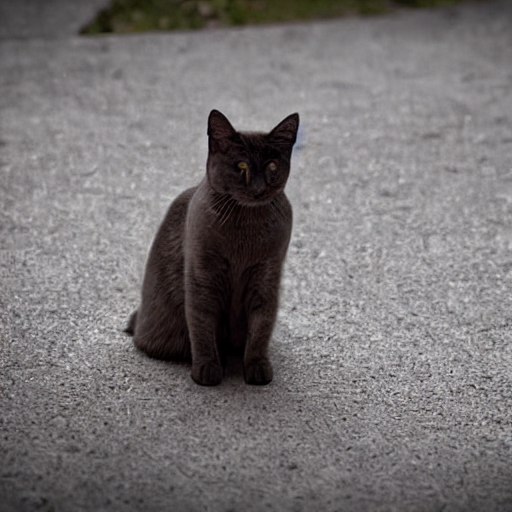

In [46]:
from PIL import Image
Image.open('/mnt/home/syn4det/LVIS_gen_FG_11/cat_44.png')

In [4]:
import random
def sample_instance_pool(raw_pool,bar=25,belief=1,samples=150000):
    g=[]
    for name in name_to_id:
        this_bar=min(bar,raw_pool[name][-1][0]-belief)
        for p in raw_pool[name]:
            if p[0]>this_bar:
                g.append((name_to_id[name],p[1]))
    print(len(g))
    return random.sample(g,samples)

In [6]:
len(sample_instance_pool(retrieval_pool,21,1,150000))
sample_instance_pool(stable_pool,21,1,150000)[0]

1091423
1355517


(700,
 '/mnt/home/syn4det/LVIS_gen_FG_3/motor_scooter_78.png|/mnt/home/syn4det/reseg/clipseg/LVIS_gen_FG_3/motor_scooter_78.png')

In [7]:
import json
def dump(pool,name):
    outpool={i:[] for i in range(1203)}
    for i in pool:
        outpool[i[0]].append(i[1])
    os.makedirs('/mnt/home/syn4det/instance_pools/',exist_ok=True)
    save_pool_name='/mnt/home/syn4det/instance_pools/{}.json'.format(name)
    with open(save_pool_name,'w') as f:
        json.dump(outpool,f)
    a=open('/mnt/home/Detic/configs/ablation_temp/template.yaml').read()
    with open('/mnt/home/Detic/configs/ablation_temp/{}.yaml'.format(name),'w') as f:
        f.write(a.format(save_pool_name))

def set_experiment(bar,retr=0,stable=0,ext=''):
    name=f'b{bar}_retr{retr}_stable{stable}'+ext
    pool=sample_instance_pool(retrieval_pool,bar,1,retr)+sample_instance_pool(stable_pool,bar,1,stable)
    dump(pool,name)
    return name
    

In [62]:
s1=[set_experiment(bar,150000,150000) for bar in [0,21,22,23,24,25,26]]


1219869
1443275
1091423
1355517
1047141
1300876
982116
1221806
888663
1112983
764799
972371
614749
800430


In [63]:
s2=[set_experiment(25,i,i) for i in [100000,150000,200000,250000,300000]]

764799
972371
764799
972371
764799
972371
764799
972371
764799
972371


In [8]:
# set_experiment(25,300000,0)
# set_experiment(25,0,300000)
# set_experiment(20,150000,150000)
#set_experiment(21,1000000,1000000)
set_experiment(21,1000000,0)

1091423
1355517


'b21_retr1000000_stable0'